# package


In [141]:
import numpy as np
import pandas as pd
import datetime
from sklearn.decomposition import PCA

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

from statsmodels.tsa.arima_model import ARMA
from matplotlib import pyplot as plt
%matplotlib inline

# data

## training data


In [145]:
def data_pro(table):
    df=pd.read_csv(table,header=0)
    N=len(df["SYM_ROOT"].unique())
    symbol=df["SYM_ROOT"].unique()
    volume=[[] for _ in range(N)]
    k=0
    for s in symbol:
        df_t=df[df['SYM_ROOT']==s]
        Pt=[]
        St=[]
        T=[]
        i=-1
        for j in range(len(df_t['TIME_M'])):
            if np.array(df_t['TIME_M'])[j][:-13] not in T:
                i+=1
                T.append(np.array(df_t['TIME_M'])[j][:-13])
                Pt.append(np.array(df_t['PRICE'])[j])
                St.append(np.array(df_t['SIZE'])[j])
            else:
                St[i]+=np.array(df_t['SIZE'])[j]
        pt=[]
        st=[]
        tt=[]
        start=datetime.datetime.strptime("09:30", "%H:%M")
        j=0
        for i in range(390):
            tt.append(start)
            if j<len(T):
                if start==datetime.datetime.strptime(T[j],'%H:%M'):

                    pt.append(Pt[j])
                    st.append(St[j])
                    j+=1
                else:
                    pt.append(pt[-1])
                    st.append(0)
            else:
                pt.append(pt[-1])
                st.append(0)
            start+=datetime.timedelta(0,60)
        volume[k]=st
        k+=1
    vol = np.array(volume)
    table=pd.DataFrame(index=tt,columns=symbol)
    k=0
    for i in symbol:
        table[i]=vol[k]
        k+=1
    return table

In [146]:
table = data_pro("10.15_combined.csv")
table.tail()

/Users/xia/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,ANF,CTB,DRE,IVZ,KIM,MAC,PCH,SYMC,VTR
1900-01-01 15:55:00,18024,3291,43174,15564,24465,16970,8139,25234,33669
1900-01-01 15:56:00,49061,3713,74010,59117,16909,25470,2635,37220,44253
1900-01-01 15:57:00,20343,6434,19814,61603,7832,26841,6349,22175,28658
1900-01-01 15:58:00,30232,8559,81626,24408,64674,43795,11901,50648,51537
1900-01-01 15:59:00,105059,17059,182096,122518,186465,60150,28401,156683,74867


## trade data

In [147]:
table2 = data_pro("10.16.csv")
table2.head()

/Users/xia/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,ANF,CTB,DRE,IVZ,KIM,MAC,PCH,SYMC,VTR
1900-01-01 09:30:00,10370,7116,19301,16625,88501,10319,5928,202243,24708
1900-01-01 09:31:00,1054,200,8023,1163,18184,120,0,26065,664
1900-01-01 09:32:00,302,0,1698,1364,25668,2852,0,13150,1278
1900-01-01 09:33:00,6140,1822,6127,149464,14477,0,100,20742,2658
1900-01-01 09:34:00,2965,216,1683,20620,15987,3506,100,7200,1850


# for loop

In [152]:
def pca_model(x):
    pca=PCA()
    pca.fit(x)
    u = pca.components_
    lmb = pca.singular_values_
    C = np.dot(x, u)
    C = C.T
    x_mean = pca.mean_
    return x_mean,C

In [85]:
c_1=pca_model(table)[0][0]+pca_model(table)[1][0]
y_1=table['CAG']-c_1

In [154]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]
from statsmodels.stats.diagnostic import acorr_ljungbox
def test_stochastic(ts):
    p_value = acorr_ljungbox(ts, lags=1)[1] #lags可自定义
    return p_value

In [155]:
def diff():
    data = pd.Series(y_1)
    k=0
    while test_stationarity(data)>0.1:
        data = data.diff().dropna()
        k+=1
    #print(test_stochastic(data)<0.1)
    return k
diff()

0

In [170]:
def arma_model(fig1,k,fig2):
    data = pd.Series(y_1)
    model = ARIMA(data, order=(fig1,k,fig2))
    model_fit = model.fit(disp=-1)
    if  k<=2:
        forecast = model_fit.forecast(steps = 1)[0]
    else:
        forecast=model_fit.forecast(steps = 1)[0]+data[-1]
    return forecast

#### loop part

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/sit

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequen

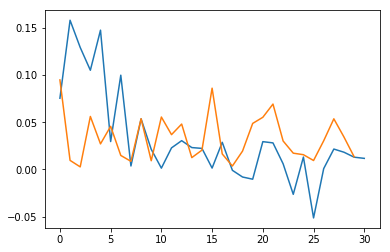

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored wh

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


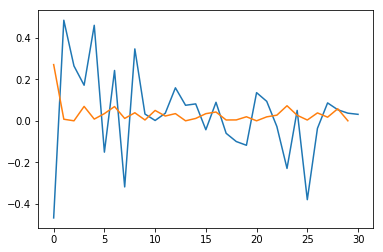

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/sit

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequen

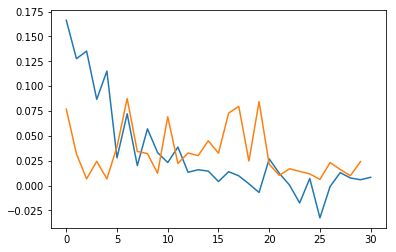

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored wh

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


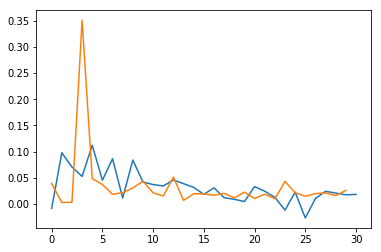

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored wh

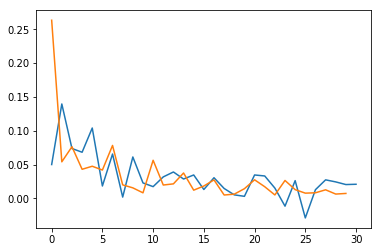

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/sit

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequen

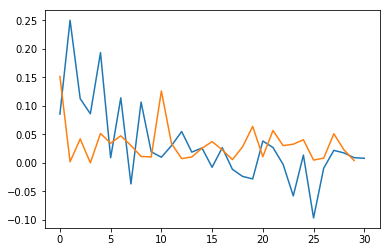

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored wh

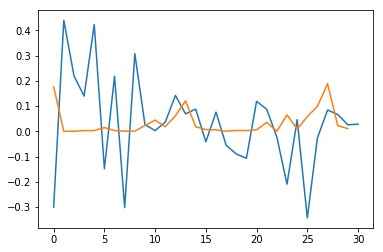

/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/xia/anaconda3/lib/python3.6/sit

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [169]:
for j in table.columns:
    tab=table
    c_1=pca_model(tab)[0][0]+pca_model(tab)[1][0]
    y_1=tab[j]-c_1
    k=diff()
    first_vol=arma_model(2,k,1).item()+c_1[0]
    vol_1016=np.array([first_vol])
    for i in range(30):
        tab=tab.append(table2[i:i+1])
        #print(tab.tail())
        c_1=pca_model(tab)[0][0]+pca_model(tab)[1][0]
        #print(len(c_1))
        y_1=tab[j]-c_1
        k=diff()
        #print(k)
        forecast=arma_model(2,k,1)
        x_1_pre=forecast+c_1[i+1]
        vol_1016=np.append(vol_1016,x_1_pre)
        
    forecast_ratio=vol_1016/np.sum(vol_1016)
    #print(forecast_ratio)
    actual=np.array(table2[j][0:30])
    actual_ratio=actual/np.sum(actual)
    #print(actual_ratio)
    plt.plot(forecast_ratio)
    plt.plot(actual_ratio)
    plt.show()